In [439]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
from operator import itemgetter
from sklearn.preprocessing import (MinMaxScaler, StandardScaler)
from sklearn.cross_validation import (cross_val_score, cross_val_predict,
                                     train_test_split, ShuffleSplit, KFold)
from sklearn.learning_curve import learning_curve
%matplotlib inline
from sklearn.metrics import (accuracy_score, roc_curve, auc, classification_report)
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.feature_selection import chi2
import statsmodels.api as sm

In [353]:
df = pickle.load(open('data.p', 'r'))
df = df.fillna(0)
# df.loc[df.winner == 1, ['win']] = 'winner'
# df.loc[df.winner==0, ['win']] = 'loser'

In [4]:
# money = ['itemproxy','unitemproxy','ieproxy','totalind','instate',
#          'itemind', 'unitemagainst', 'itemagainst' ,'unitemfor',
#          'unitemind', 'totalpacs','itempacs','unitempacs',
#          'ieagainst','itemfor', 'iefor' , 'unitemtotal',  
#          'itemtotal' ,'total', 'unitemie',  'itemie','percunitem',
#          'percpacs', 'ie', 'percie','percind','percstate','total_sc']  

# coms =['ecn' ,'tax',  'bus', 'rul', 'sci', 'tra', 'nat' ,'jud',
#        'adm' ,'gov' ,'for' ,'ene' ,'edu', 'bud', 'ban' ,'arm',
#        'app', 'pri', 'egw', 'lib', 'hsc', 'int', 'way', 'vet', 
#        'sta', 'agr']

# bio = [ 'congyear' , 'feccandid', 'party', 'candname' , 'winner', 'cpo', 'office', 'state', 'district']
# status = ['leader', 'chairman' ,'power', 'leadershipcom', 'leadership']
# election = ['close2' 'close5' 'close10', 'vap',  'generalturnout', 
#             'primaryturnout' ,  'primary' , 'primaryperc' ,  'general' ,
#             'generalperc' ]
# misc = ['majorityprev', ]

# drop = ['seat' , 'acceptpacs', 'cid',  'incumbent', 'open' , 'challenger']

In [451]:
X = df[['congyear', 'unitemagainst', 'itemagainst', 'itemind',
'unitemind', 'itempacs', 'unitempacs', 'itemfor', 
'unitemfor', 'percunitem', 'party', 'ecn' ,'tax',  'bus', 
'sci', 'tra', 'nat' ,'jud', 'adm' ,'gov' ,'for' ,
'ene' ,'edu', 'bud', 'ban' ,'arm','app', 'pri',
'egw', 'lib', 'hsc', 'int', 'way', 'vet', 'sta', 'agr',
'rul']].join(pd.get_dummies(df['cpo']))
y = df['winner']

# dataframe1 = df[['unitemagainst', 'itemagainst', 'itemind',
# 'unitemind', 'itempacs', 'unitempacs', 'itemfor', 
# 'unitemfor', 'percunitem']]

# dataframe2 = df[['congyear', 'party', 'ecn' ,'tax',  'bus', 
# 'sci', 'tra', 'nat' ,'jud', 'adm' ,'gov' ,'for' ,
# 'ene' ,'edu', 'bud', 'ban' ,'arm','app', 'pri',
# 'egw', 'lib', 'hsc', 'int', 'way', 'vet', 'sta', 'agr',
# 'rul']].join(pd.get_dummies(df['cpo']))

### Defining functions

In [430]:
def max_k(X, y, n=20):
    temp = {}
    cv = KFold(X.shape[0], n_folds=5, random_state=1)
    for i in range(1, n+1):
        temp[i] = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=i), X, y, scoring='accuracy', cv=cv))                
    
    k = int(max(temp.iteritems(), key=itemgetter(1))[0])
    acc = float(max(temp.iteritems(), key=itemgetter(1))[1])    
    return k, acc



def graph_learning_curve(model, X, y, title):
    m,train_err,ts_err = learning_curve(model,X,y,
                                    train_sizes=np.linspace(0.4, 1.0, 50))
    train_cv_err = np.mean(train_err,axis=1)
    test_cv_err = np.mean(ts_err,axis=1)
    tr, =plt.plot(m,train_cv_err)
    ts, = plt.plot(m,test_cv_err)
    plt.legend((tr,ts),('training','test'),loc='best')
    plt.title('title')
    return plt.show()
    

def make_roc(mod, X, y, title):
    model = mod
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)
    model.fit(X_train, y_train)
    try:
         y_score = mod.fit(X_train, Y_train).decision_function(X_test)
    except:
        y_score = (mod.fit(X_train, Y_train).predict_proba(X_test))[:,1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    alg_label = str(alg)
    alg_label = alg_label[:alg_label.index('(')]
    plt.plot(fpr[i], tpr[i], label='ROC curve of ' + alg_label+ '  (area = {1:0.2f})'.format(alg_label, roc_auc[i]))
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    labelname = title + ", (area = %0.3f)" % area
    plt.legend(loc = 4)
    plt.show()

def get_metrics(X, y, model_dic):
    for mname, m in model_dic.iteritems():
        print '\n*** %s' % mname
        acc = np.mean(cross_val_score(m, X, y, scoring='accuracy'))
        pre = np.mean(cross_val_score(m, X, y, scoring='precision'))
        rec = np.mean(cross_val_score(m, X, y, scoring='recall'))
        f1 = np.mean(cross_val_score(m, X, y, scoring='f1'))
        ll = np.mean(cross_val_score(m, X, y, scoring = 'log_loss'))
        print 'cv score: %f' % np.mean(cross_val_score(m, X, y))
        print 'accuracy: %f' % acc
        print 'precision: %f' % pre
        print 'recall: %f' % rec
        print 'f1 score: %f' % f1
        print 'logloss score: %f' %-ll


def preprocess(dataframe1, dataframe2):
    scaler = preprocessing.StandardScaler()
    data_scaled = scaler.fit_transform(dataframe1)
    preproc_data = pd.DataFrame(data_scaled)
    preproc_data.columns = dataframe1.columns
    data = preproc_data.join(dataframe2)
    return data

In [381]:
n_samples = X.shape[0]
cv = ShuffleSplit(n_samples, n_iter=5, test_size=0.3, random_state=0)
clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression())
cross_val_score(clf, X, y, cv=cv)

array([ 0.85967504,  0.87592319,  0.88330871,  0.89660266,  0.87592319])

In [457]:
# X = preprocess(dataframe1, dataframe2)
# y = df['winner']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
# X = preprocess(dataframe1, dataframe2)
# def get_scores_coef(model_dict):
#     for mname, m in model_dict.iteritems():
#         print "*** %s" % mname
#         m.fit(X_train, y_train)
#         preds = m.predict(X_test)
#         proba = m.predict_proba(X_test)
#         print 'accuracy: %f' % accuracy_score(y_test, preds)
#         print 'precision: %f' % precision_score(y_test, preds)
#         print 'recall: %f' % recall_score(y_test, preds)
#         print 'f1 score: %f' % f1_score(y_test, preds)
#         print '\n'
#         coefs = sorted(zip(m.coef_[0], X_train.columns))
#         for coef in coefs:
#             print '%.05f \t%s' % (coef)
      
#         return coefs
    
# get_scores_coef({'logistic': LogisticRegression()})
# X['intercept'] = 1.

X = df[['congyear', 'unitemagainst']].join(pd.get_dummies(df['cpo']))
X['intercept'] = 1.
y = df['winner']
logit = sm.Logit(y, X)
res = logit.fit()
res.summary()


         Current function value: 0.366801
         Iterations: 35


/Users/Julia/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 winner   No. Observations:                 2256
Model:                          Logit   Df Residuals:                     2251
Method:                           MLE   Df Model:                            4
Date:                Mon, 02 Nov 2015   Pseudo R-squ.:                  0.4662
Time:                        15:44:31   Log-Likelihood:                -827.50
converged:                      False   LL-Null:                       -1550.3
                                        LLR p-value:                8.970e-312
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
congyear         -0.0111      0.079     -0.140      0.889        -0.166     0.144
unitemagainst -7.065e-07    2.8e-07     -2.519      0.012     -1.26e-06 -1.57e-07
C                -2.1567   9.23e+06  -2.34e-07      1.000     -1.81e+07  1.81e+07
I                 2.2354   9.23e+06   2.42e-07      1.000     -1.81e+07  1.81e+07
O                 0.0562   9.23e+06   6.09e-09      1.000     -1.81e+07  1.81e+07
intercept         0.1349   9.23e+06   1.46e-08      1.000     -1.81e+07  1.81e+07
=================================================================================
"""

NameError: global name 'Y_train' is not defined

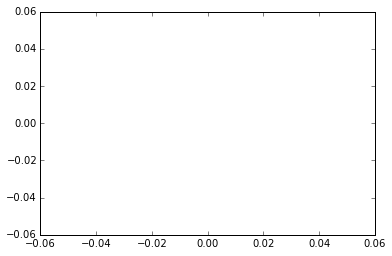

In [449]:
model_dic = {'log': LogisticRegression(),
            'log_scaled': make_pipeline(preprocessing.StandardScaler(), LogisticRegression())}

plt.plot()     
make_roc(make_pipeline(preprocessing.StandardScaler(), LogisticRegression()), X, y, "title")


In [411]:
X = df[['congyear', 'unitemagainst', 'itemagainst', 'itemind',
'unitemind', 'itempacs', 'unitempacs', 'itemfor', 
'unitemfor', 'percunitem', 'party', 'ecn' ,'tax',  'bus', 
'sci', 'tra', 'nat' ,'jud', 'adm' ,'gov' ,'for' ,
'ene' ,'edu', 'bud', 'ban' ,'arm','app', 'pri',
'egw', 'lib', 'hsc', 'int', 'way', 'vet', 'sta', 'agr',
'rul']].join(pd.get_dummies(df['cpo']))
y = df['winner']

In [416]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
log = LogisticRegression()
log.fit(X_train, y_train).predict(X_test)
log.coef_
# # coefs = sorted(zip(log.coef_[0], X_train.columns))
# # for coef in coefs:
# #     print '%.05f \t%s' % (coef)
# # log.coef_
# # zip(list(X_train.columns), round(log.coef_[0], 3))
# np.round(log.coef_, 6)

array([[ -1.89892201e-09,  -1.55476492e-06,  -5.27957867e-07,
         -1.44612180e-07,  -7.80186563e-08,   4.62189817e-06,
          1.63323469e-06,  -5.36755706e-07,  -3.29410946e-06,
         -4.02873017e-10,  -1.29143194e-09,   5.36489073e-12,
          6.46326712e-12,   9.12009269e-12,   4.67573890e-11,
          1.72458673e-11,   7.54089075e-11,   5.22456759e-11,
          1.34723956e-11,   6.13568368e-11,   6.34307622e-11,
          3.78943776e-11,   7.13184727e-11,   2.66465843e-11,
          4.51107130e-11,   6.34533510e-11,   6.67249215e-11,
          8.17461439e-12,   1.31932240e-11,   9.45120521e-12,
          3.67251319e-11,   4.10281096e-11,   1.85578409e-11,
          7.22518722e-12,   1.40987826e-11,   6.74754970e-12,
          1.95342182e-11,  -1.28158179e-09,   3.71668471e-10,
         -5.03048280e-11]])

In [ ]:
for mname, m in model_dic.iteritems():
    coefs = sorted(zip(m.coef_[0], X_tr.columns))
        for coef in coefs:
            print '%.05f \t%s' % (coef)
        all_preds[mname] = preds
        all_proba[mname] = proba
        return coefs


### Starting with logistic

### Learning Curve 

In [ ]:
scoresTrain = []
scoresTest=[]
for i in range(1, 21):
        temp[i] = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=i), X, y, scoring='accuracy', cv=cv))  
    
    
    
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train.ravel())
    y_train_pred = model.predict(X_train)
    scoresTrain.append(accuracy_score(y_train, y_train_pred))
    y_test_pred = model.predict(X_test)
    scoresTest.append(accuracy_score(y_test, y_test_pred))


In [62]:
def plot_learning_curve(estimator,X, y):
    plt.figure()

#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
    cv = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.3, random_state=1)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



    

<module 'matplotlib.pyplot' from '/Users/Julia/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

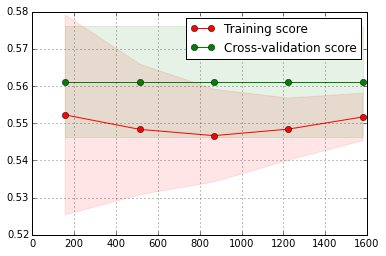

In [75]:
plot_learning_curve(LogisticRegression(), X, y)

# ROC

In [324]:
def graph_roc(model, X, y, title):
    m,train_err,ts_err = learning_curve(model,X,y,
                                    train_sizes=np.linspace(0.4, 1.0, 50))
    train_cv_err = np.mean(train_err,axis=1)
    test_cv_err = np.mean(ts_err,axis=1)
    tr, =plt.plot(m,train_cv_err)
    ts, = plt.plot(m,test_cv_err)
    plt.legend((tr,ts),('training','test'),loc='best')
    plt.title('title')
    return plt.show()